In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

import CompPhy as cp

plt.style.use("custom.matplotlibrc")

# Implementation of Exact Results

1 / J       m          e   
 0.25   1.0000000   -8.000 
 1.0    0.9992758   -1.997 
 2.0    0.9113194   -0.873 
 3.0    0.0000000   -0.272 


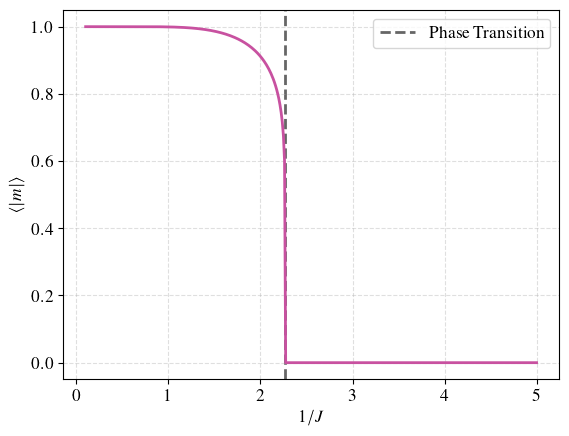

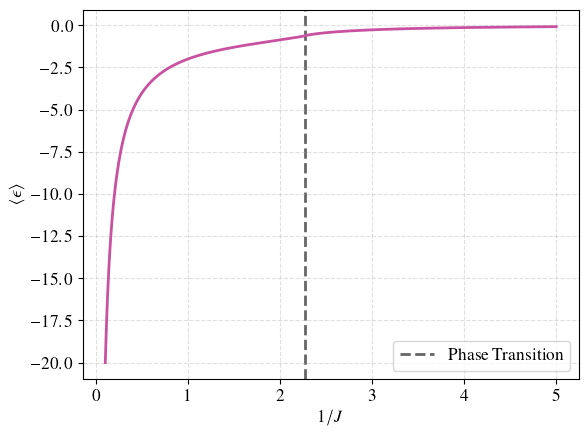

In [3]:
J_c = 0.5 * np.log(1 + np.sqrt(2))


@np.vectorize
def mean_mag_per_site(J):

    if J <= J_c:
        return 0

    return np.power(1 - 1 / np.sinh(2 * J) ** 4, 0.125)


def mean_energy_per_site(J):
    tanh2 = np.tanh(2 * J) ** 2
    fac = -J * np.cosh(2 * J) / np.sinh(2 * J)
    term1 = 2 * tanh2 - 1
    term2 = scipy.special.ellipk(4 * (1 - tanh2) * tanh2)

    return fac * (1 + 2 / np.pi * term1 * term2)


# Proof that it works
print("{:^6}".format("1 / J"), "{:^12}".format("m"), "{:^7}".format("e"))
for J in [4, 1, 0.5, 1 / 3]:
    j = "{:^6}".format(1 / J)
    m = "{:^12.7f}".format(mean_mag_per_site(J))
    e = "{:^7.3f}".format(mean_energy_per_site(J))
    print(j, m, e)

var = np.linspace(0.1, 5, 400)

# mag per site
plt.figure(0)
plt.plot(var, mean_mag_per_site(1 / var), linewidth=2)
plt.xlabel(r"$1 / J$")
plt.ylabel(r"$\expval{\abs{m}}$")
plt.grid(alpha=0.4, linestyle="--")
plt.axvline(
    1 / J_c,
    label="Phase Transition",
    color="black",
    linestyle="--",
    alpha=0.6,
    linewidth=2,
    zorder=0,
)
plt.legend()
plt.savefig(r"Exercise_5/mean_mag_per_site.pdf")

# e per site
plt.figure(1)
plt.plot(var, mean_energy_per_site(1 / var), linewidth=2)
plt.xlabel(r"$1 / J$")
plt.ylabel(r"$\expval{\epsilon}$")
plt.grid(alpha=0.4, linestyle="--")
plt.axvline(
    1 / J_c,
    label="Phase Transition",
    color="black",
    linestyle="--",
    alpha=0.6,
    linewidth=2,
    zorder=0,
)
plt.legend()
plt.savefig(r"Exercise_5/mean_energy_per_site.pdf")

# MCMC in 2D

In [11]:
from CompPhy.mcmc import Ising2D


ising = Ising2D(1, 0, 20)

start = np.array([[1] * 20] * 20)

configs = ising(200, start)

x = configs.mean(axis=(1, 2))

plt.plot(range(len(x)), x)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()